In [2]:
import numpy as np
import pandas as pd

In [3]:
abc_df = pd.read_csv('ABC_Feature_Matrix_Random.csv')
jwst_df = pd.read_csv('Interpolated_WASP-39b.csv')

In [4]:
x_spec = abc_df.iloc[:, 1:53]
y = abc_df.iloc[:, 53]

In [5]:
x_jwst = jwst_df.iloc[:,1:]

In [6]:
#Train Test Split
from sklearn.model_selection import train_test_split
x_spec_train, x_spec_test, y_train, y_test = train_test_split(x_spec, y, test_size = 0.2, random_state = 42)

In [7]:
X_train = x_spec_train.to_numpy()
X_test = x_spec_test.to_numpy()
X_jwst = x_jwst.to_numpy()

In [8]:
from sklearn.preprocessing import Normalizer

#Normalization using norm = max

scaler_norm = Normalizer(norm = 'max')

x_train_nmax = scaler_norm.fit_transform(X_train)
x_test_nmax = scaler_norm.transform(X_test)
x_jwst_nmax = scaler_norm.transform(X_jwst)

In [9]:
y_train = np.log1p(y_train)
y_test   = np.log1p(y_test)

In [9]:
import optuna
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_nmax, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    # Depth: restrict to 1–2 layers (3+ is too slow)
    n_layers = trial.suggest_int("n_layers", 1, 2)

    # Width: 64–192 units per layer (good speed/accuracy balance)
    hidden_layer_sizes = tuple([
        trial.suggest_int(f"units_l{i}", 64, 192, step=64)
        for i in range(n_layers)
    ])

    params = {
        "hidden_layer_sizes": hidden_layer_sizes,

        "activation": "relu",

        "alpha": trial.suggest_float("alpha", 1e-6, 1e-2, log=True),

        "beta_1": trial.suggest_float("beta_1", 0.85, 0.93),
        "beta_2": trial.suggest_float("beta_2", 0.90, 0.98),

        "shuffle": trial.suggest_categorical("shuffle", [True, False]),
        "n_iter_no_change": trial.suggest_int("n_iter_no_change", 5, 10),

        "solver": "adam",
        "learning_rate": "adaptive",
        "learning_rate_init": trial.suggest_float("learning_rate_init", 5e-4, 5e-3, log=True),

        "batch_size": trial.suggest_categorical("batch_size", [128, 256]),

        "max_iter": 250,
        "early_stopping": True,
        "validation_fraction": 0.15,
        "random_state": 42,
    }

    model = MLPRegressor(**params)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_val)
    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-11-26 10:58:30,749] A new study created in memory with name: no-name-2914c395-7c9c-4d40-a98e-c177ee09df59


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-26 10:58:44,460] Trial 0 finished with value: 0.7489236707670363 and parameters: {'n_layers': 1, 'units_l0': 128, 'alpha': 2.1055603517093326e-06, 'beta_1': 0.9019814742109399, 'beta_2': 0.9700083311115103, 'shuffle': False, 'n_iter_no_change': 6, 'learning_rate_init': 0.0018878298517339411, 'batch_size': 128}. Best is trial 0 with value: 0.7489236707670363.


C:\Users\Hamshith\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-11-26 10:59:11,138] Trial 1 finished with value: 0.8196394388099285 and parameters: {'n_layers': 1, 'units_l0': 64, 'alpha': 1.5134636026528736e-06, 'beta_1': 0.8519675145009383, 'beta_2': 0.9563031191171844, 'shuffle': True, 'n_iter_no_change': 9, 'learning_rate_init': 0.002008238434152433, 'batch_size': 256}. Best is trial 1 with value: 0.8196394388099285.
[I 2025-11-26 10:59:33,140] Trial 2 finished with value: 0.6574001208038289 and parameters: {'n_layers': 2, 'units_l0': 64, 'units_l1': 192, 'alpha': 0.0020506856461727165, 'beta_1': 0.8567038166003335, 'beta_2': 0.9588006083047869, 'shuffle': False, 'n_iter_no_change': 7, 'learning_rate_init': 0.004608143210762797, 'batch_size': 256}. Best is trial 1 with value: 0.8196394388099285.
[I 2025-11-26 10:59:40,430] Trial 3 finished with value: 0.6371846537841204 and parameters: {'n_layers': 1, 'units_l0': 64, 'alpha': 1.6916770980064162e-05, 'beta_1': 0.8541143053850594, 'beta_2': 0.9599265717770666, 'shuffle': True, 'n_iter_no_

In [10]:
best = study.best_params

# Rebuild hidden_layer_sizes
n_layers = best["n_layers"]
hidden_layer_sizes = tuple([
    best[f"units_l{i}"] for i in range(n_layers)
])

# Remove Optuna-only keys
best_nmax = best.copy()
best_nmax.pop("n_layers")
for i in range(n_layers):
    best_nmax.pop(f"units_l{i}")

# Inject the real MLP param
best_nmax["hidden_layer_sizes"] = hidden_layer_sizes

mlp_nmax = MLPRegressor(**best_nmax)
mlp_nmax.fit(x_train_nmax, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.001327578980447055
,batch_size,128
,learning_rate,'constant'
,learning_rate_init,0.0005017050062580267
,power_t,0.5
,max_iter,200
,shuffle,True


In [9]:
from sklearn.neural_network import MLPRegressor
best_nmax =  {'alpha': 0.001327578980447055, 'beta_1': 0.923244140485141, 'beta_2': 0.9690614137175975, 'shuffle': True, 'n_iter_no_change': 8, 'learning_rate_init': 0.0005017050062580267, 'batch_size': 128, 'hidden_layer_sizes': (128, 128)}
mlp_nmax = MLPRegressor(**best_nmax)
mlp_nmax.fit(x_train_nmax, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.001327578980447055
,batch_size,128
,learning_rate,'constant'
,learning_rate_init,0.0005017050062580267
,power_t,0.5
,max_iter,200
,shuffle,True


In [10]:
import joblib

mlp_nmax=joblib.load( "mlp_nmax.pkl")


In [11]:
y_test_pred_nmax =  mlp_nmax.predict(x_test_nmax)

In [12]:
from sklearn.metrics import r2_score

results = {
    "mlp_nmax": [r2_score(y_train, mlp_nmax.predict(x_train_nmax)), r2_score(y_test, mlp_nmax.predict(x_test_nmax))]
}

In [13]:
result_df = pd.DataFrame(results, index=["train", "test"])
result_df

,mlp_nmax
train,0.839295
test,0.838991


In [16]:
from sklearn.metrics import mean_absolute_error

results_mae = {
    "mlp_nmax": [mean_absolute_error(y_train, mlp_nmax.predict(x_train_nmax)), mean_absolute_error(y_test, mlp_nmax.predict(x_test_nmax))]
}

result_mae_df = pd.DataFrame(results_mae, index=["train", "test"])
result_mae_df

,mlp_nmax
train,0.142668
test,0.141888


In [15]:
from sklearn.metrics import mean_squared_error

results_mse = {
    "mlp_nmax": [mean_squared_error(y_train, mlp_nmax.predict(x_train_nmax)), mean_squared_error(y_test, mlp_nmax.predict(x_test_nmax))]
}

result_mse_df = pd.DataFrame(results_mse, index=["train", "test"])
result_mse_df

,mlp_nmax
train,0.049568
test,0.048765


In [17]:
result_rmse_df = np.sqrt(result_mse_df)
result_rmse_df

,mlp_nmax
train,0.222640
test,0.220827


In [13]:
y_nmax = np.expm1(mlp_nmax.predict(x_jwst_nmax))

In [14]:
print("MLP NMAX: ", y_nmax.mean(axis = 0))

MLP NMAX:  5.372039315631633


In [15]:
print("mlp nmax params : ",best_nmax)

mlp nmax params :  {'alpha': 0.001327578980447055, 'beta_1': 0.923244140485141, 'beta_2': 0.9690614137175975, 'shuffle': True, 'n_iter_no_change': 8, 'learning_rate_init': 0.0005017050062580267, 'batch_size': 128, 'hidden_layer_sizes': (128, 128)}


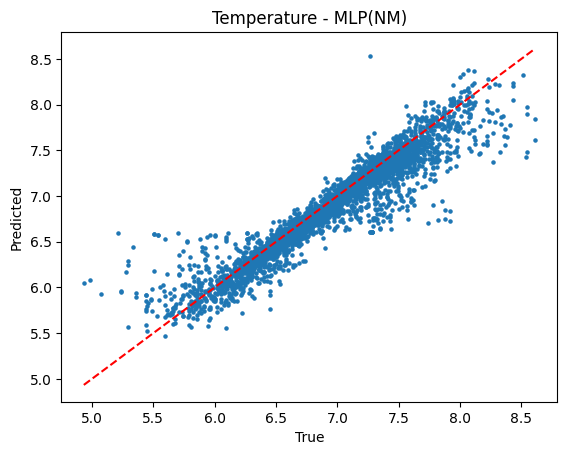

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(y_test, y_test_pred_nmax, s=5)

m = min(y_test.min(), y_test_pred_nmax.min())
M = max(y_test.max(), y_test_pred_nmax.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature - MLP(NM)")
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_11372\4248404746.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_11372\4248404746.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_11372\4248404746.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

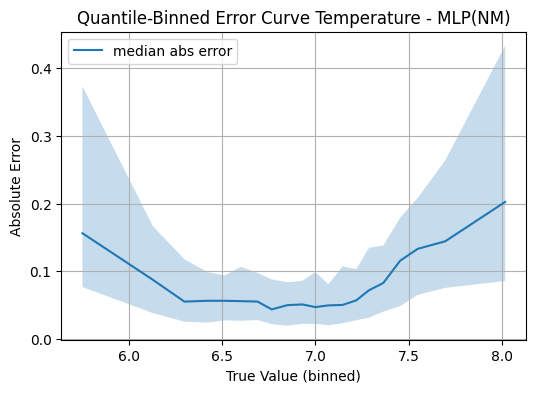

In [18]:
true = y_test       # 1D array
pred = y_test_pred_nmax  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature - MLP(NM)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import joblib

# suppose your trained model is 'model'
joblib.dump(mlp_nmax, "mlp_nmax.pkl")


['mlp_nmax.pkl']